## Using Clustering to Classify the "Online Shoppers Purchasing Intention" Dataset
#### By Kyle Hayes

**Summary**

In this project, I will:
* Determine whether datapoints in the "Online Shoppers Purchasing Intention" dataset can be classified into naturally-occurring categories using several clustering techniques.
* Select a clustering technique, and use it to determine each datapoint's category.
* Interpret and label the categories by plotting these clusters.
* Determine the efficacy of these labels using a classification model, and interpret the results.

I obtained the "Online Shoppers Purchasing Intention" dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset). The purpose of the original study was to predict whether an online shopper was likely or unlikely to make a purchase. The authors obtained from Google Analytics 12230 instances in which a separate potential customer entered a retail website. The dataset includes the following information about each instance:

* **Administrative:** The number of account management pages the user visited (ex. login pages, password recovery pages, etc.). These are pages defined by one of the following urls: /?login, /?logout, /LoginRegister, /login', /passwordrecovery, /?ref, /?refer, /?returnurl, /customer, /emailwishlist, /omnicards.

* **Administrative_Duration:** Total amount of time (in seconds) spent by the visitor on administrative pages.

* **Informational:** The number of pages the user visited about the website, the store address, or store communications (ex. store locations, the "Contact Us" page, etc.). These pages are defined by one of the following urls: /Topic, /t-popup, /t, /contactus, /Catalog, /stores.

* **Informational_Duration:** Total amount of time (in seconds) spent by the visitor on informational pages.

* **Product:** The number of pages the user visited related to products (ex. product searches, the "shopping cart" page, etc.). These are pages defined by one of the following urls: /, /c, /urun, /search, /cart.

* **Product_Duration:** Total amount of time (in seconds) spent by the visitor on product pages.

* **Bounce Rates:** The average bounce rate for the pages visited. A page's bounce rate is defined as the overall percentage of users that enter a site using the page in question, and leave without interacting with the page.

* **Exit Rates:**  The average exit rate for the pages visited. A page's exit rate is defined as the percent of users that leave the website immediately after interacting with the page.

* **Page Value:** The average page value for the pages visited. A page's page value is defined by the average value that the page produces (how much users spend on average after visiting the page).

* **Special Day:** How close the visit was to a holiday for which users commonly purchase gifts (ex. Mother's Day, Valentine's Day, etc.). The authors normalized this variable to a [0, 1] range.

* **Month:** The month in which the visit took place.

* **Operating System:** The operating system (ex. Windows, IOS, etc.) used by the shopper.

* **Browser:** The browsing system (ex. Chrome, Safari, etc.) used by the shopper.

* **Region:**  The geographic region from which the shopper initiated the session.

* **Traffic Type:** The traffic source by which the shopper accessed the website (ex. direct, banner, etc.).

* **Visitor Type:** Whether the shopper was a new visitor, a returning visitor, or "other". Note: the authors do not describe what "other" refers to.

* **Weekend:** Boolean, describes whether the visit took place on a weekend.

* **Revenue:** Boolean, describes whether the visit ended in a transaction.

Please note that for the variables "Operating System", "Browser", "Region", and "Traffic Type", the authors anonymized the data by substituting each categorical variable by a number. We will therefore be referring to each category within these variables by their number (ex. "Browser_1, etc.).

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
import data_prep as d
import functions as f
warnings.filterwarnings('ignore')
pd.set_option("max_columns", 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

Using TensorFlow backend.


## Loading the unlabeled data

Our first step will be to load the data, and preform a preliminary investigation of the first five datapoints.

In [2]:
data = pd.read_csv("data/shoppers.csv")

## Cleaning the unlabeled data

Prior to clustering the data, we will need to clean the data. This function will transform the data in the following ways:
* It will transform each nominal categorical feature with an integer datatype to a string datatype.
* For consistency, it will convert each integer or Boolean datatype to a float datatype.
* For each categorical feature, it will combine categories with low numbers of datapoints into an "other" category.
* It will create dummy variables for each categorical variable with more than two categories. In order to ensure multicollinearity, it will then remove the most common category.
* In order to increase normality, it will preform a log transformation on each continuous feature. Since these often include zero values, it will first find the minimum non-zero value for each feature, and add 1/2 this number to each zero value.
* In order to decrease outlier influence, it will cap each continuous feature's outlier values at their 99.97% quantile.
* To prepare for clustering, it will standardize the data using the StandardScaler().

Additional details for each transformation can be found on the data_prep.py page. (Note: using Variance Inflation Factor, I have already determined that none of these features possess unacceptable levels of multicollinearity.)

In [3]:
data = d.clean(data)

## Determining Cluster Technique

The three most commonly-used clustering techniques are K-Means, Agglomerative Hierarchical Clustering, and Principal Component Analysis. Prior to prefoming clustering on our unsupervised dataset, we need to determine which clustering methods to use.

In order to better understand what the clusters may look like, we will first create a pairplot. For the purposes of simplicity, we will restrict this plot to the continuous variables.

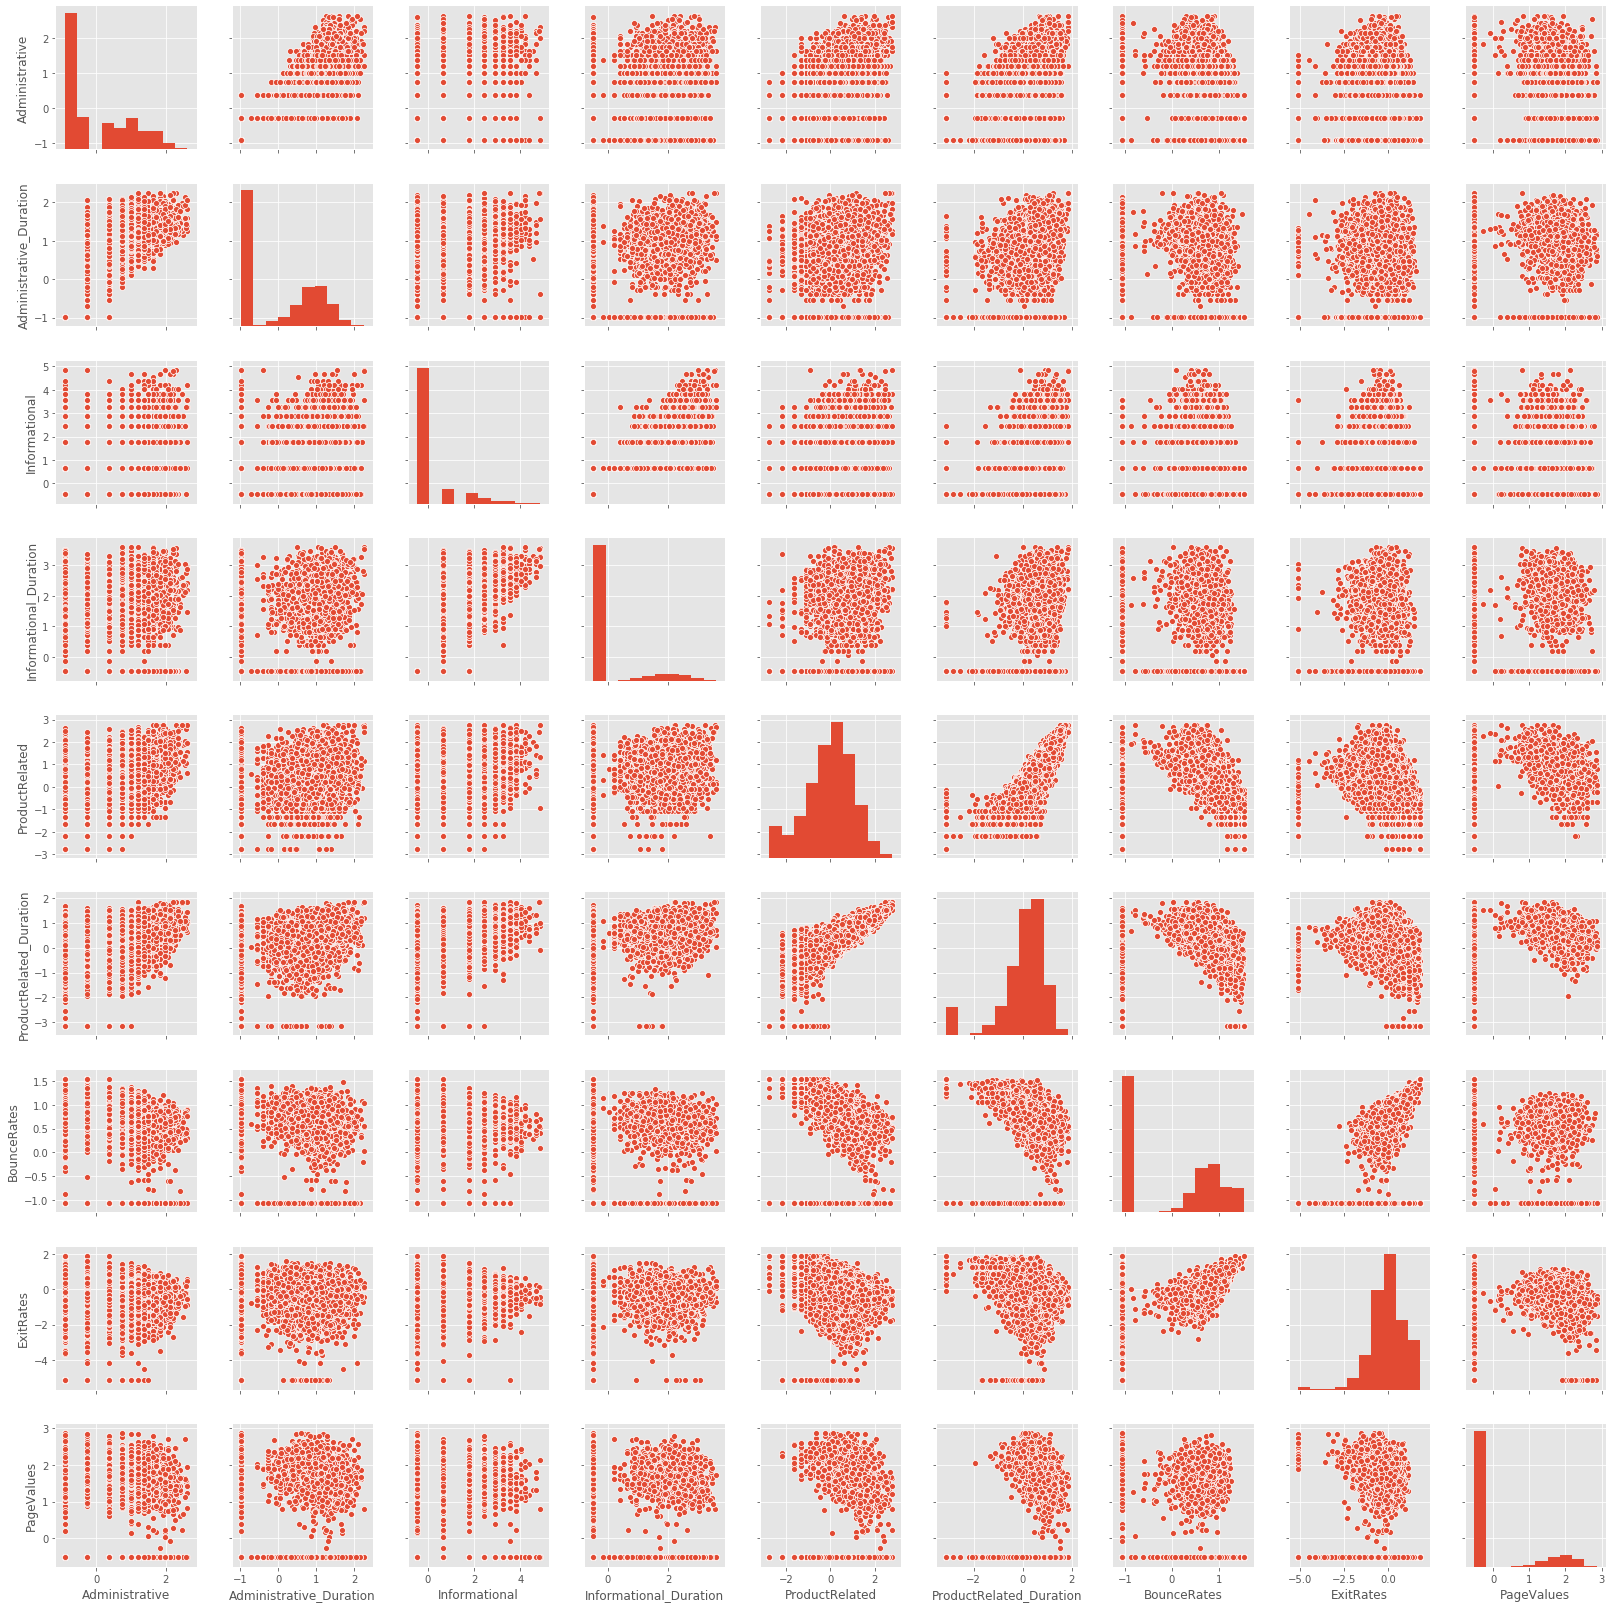

In [4]:
sns.pairplot(data.iloc[:, :9])

Although most pairs contain ovaloid groupings, most also contain non-ovaloid lines of datapoints near their respective zero values. Since these non-ovaloid groups may be difficult to detect using K-Means, using Agglomerative Hierarchical Clustering may be a better option. In addition, Agglomerative Hierarchical Clustering may help us to find different-sized clusters.

However, we also need to determine whether using PCA on the dataset will improve clustering capacities, and if so, which method we should use following dimension reduction. In addition, we still need to determine how many clusters we should use.

The following graph will show how our data preforms when clustered into a range of 2 to 10 clusters using the following clustering techniques:
* K-Means without PCA
* Agglomerative Hierarchical Clustering without PCA
* K-Means with PCA (dimensions determined by 95% variance retention level)
* Agglomerative Hierarchical Clustering with PCA (dimensions determined by 95% variance retention level)

It will use as a metric the Silhouette Score.

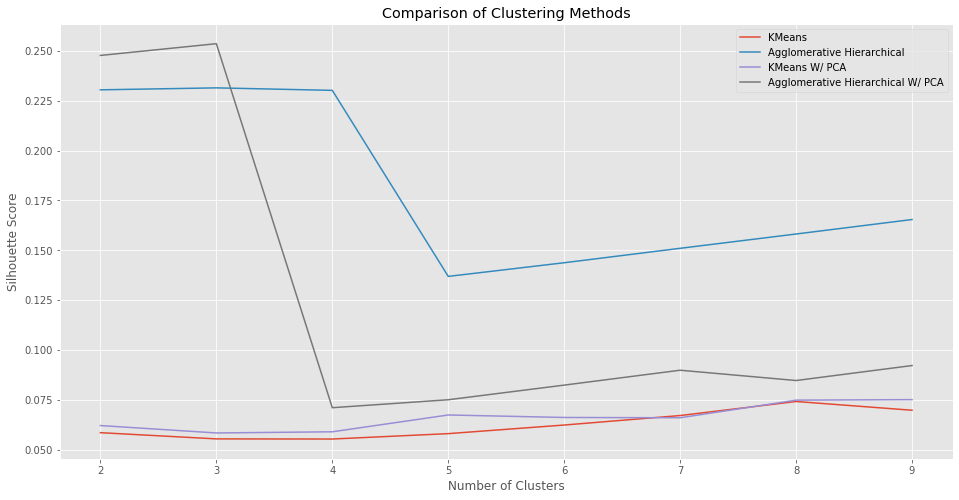

In [6]:
f.sil_score(data)

The results demonstrate the Agglomerative Hierarchical Clustering method strongly outpreforms the KMeans method. In addition, this method is also slightly improved when we use PCA.

In addition, the results demonstrate the optimal cluster number for this dataset is three clusters. We will preform principal component analysis on the data, use the Agglomerative Hierarchical Clustering method to separate each datapoint into one of three clusters, and obtain the label dataset.

In [7]:
target = f.get_targets(data, n_groups=3)

## Analyzing Cluster Properties and Determining Cluster Labels

In order to properly describe each cluster, we need to determine which features are most critical in separating the clusters.

First, we will reload and clean the original dataset. Since the relationship between the clusters and the features will be more obvious prior to the log transformations, continuous outlier capping, and standard scaling, we will skip these cleaning steps.

In [8]:
data = pd.read_csv('data/shoppers.csv')
data = d.clean(data, skip_transformations=True)

Next, we will preform a preliminary examination of the cluster sizes.

In [9]:
target['Target'].value_counts()

0    11852
1      343
2      135
Name: Target, dtype: int64

Based on this, we can see that the clusters have extremely different sizes. Cluster '2' has just above 1% of the datapoints, and cluster '1' has between 2.5% and 3% of the datapoints. The rest belong to cluster '0'. This indicates that, although we have capped outliers and grouped the least common categorical variables, the clustering feature has likely created a dichotomy (at least in some features) between datapoints with least common feature characteristics and the rest of the dataset.

Next, we will create visual representations of the cluster characteristics. Given that the dataset has over 60 features, mapping the clusters onto a 2x2 scatterplot would be needlessly complicated. For this reason, we will instead compare how individual features differ between each label.

We will first use a Random Forest Classifier to determine and graph the 10 most important features.

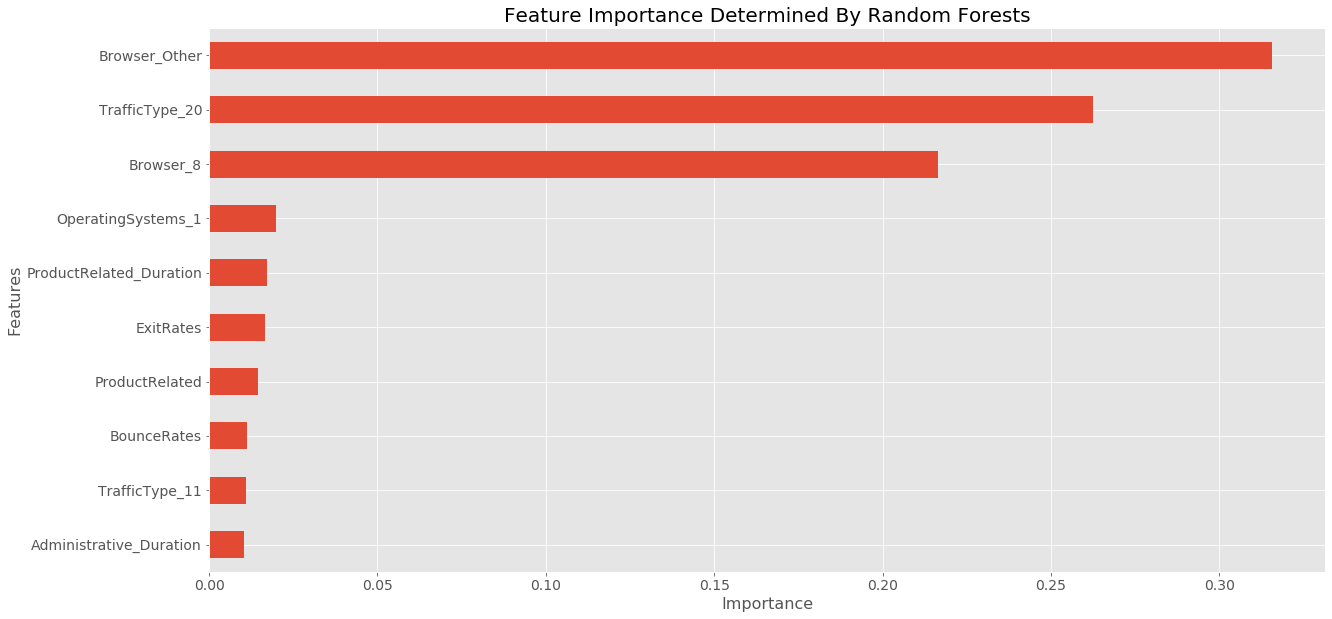

In [10]:
f.visualize_feature_importance(data, target)

From this graph, we can determine that the three most important features are the "Browser_Other" feature, the "TrafficType_20" feature, and the "Browser_8" feature. As a reminder, the "Browser_Other" feature is a combination of the rarest browser types (3, 7, 9, 11, 12, and 13), meant to ensure that no categorical variable has less than 1% of the datapoints.

In order to label the target categories properly, we will create three pairs of bar graphs describing the relationship between the cluster labels and the three most important features. The first of each pair will describe the number of datapoints in each cluster that possess the feature in question. Since we have already determined that the cluster sizes are radically different, we will also show the percentage of datapoints in each cluster that possess the feature in question.

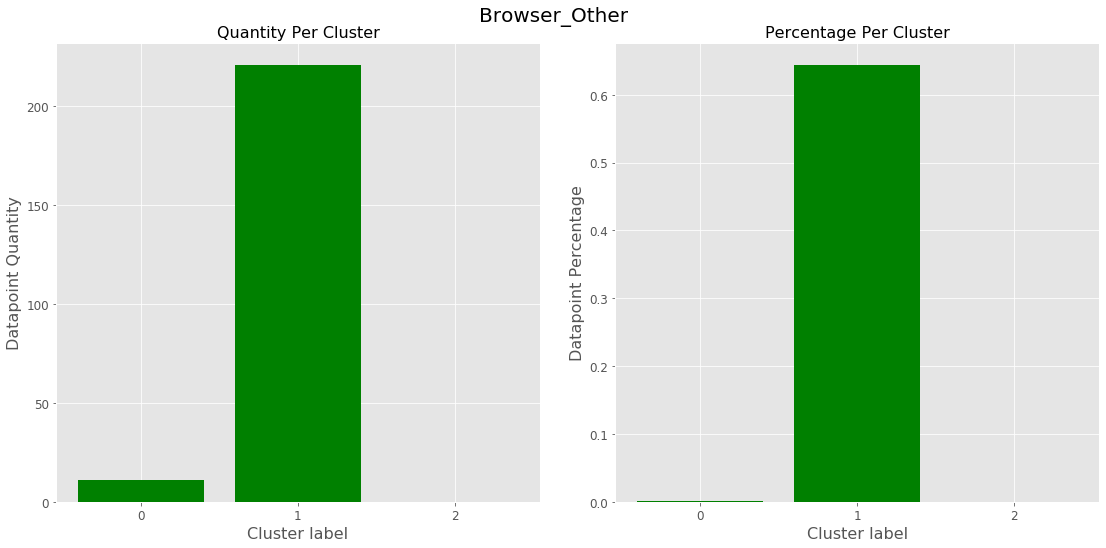

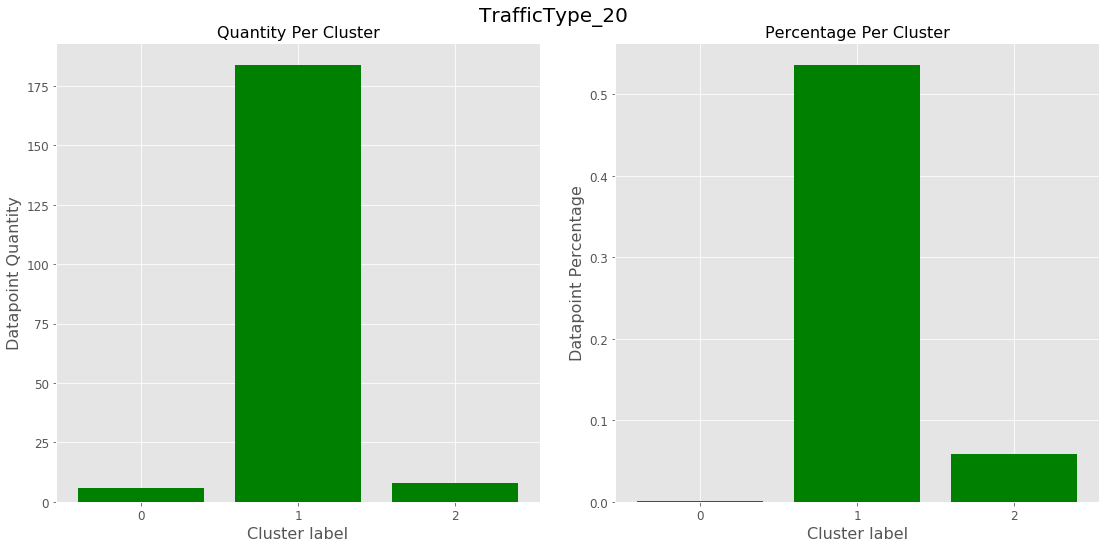

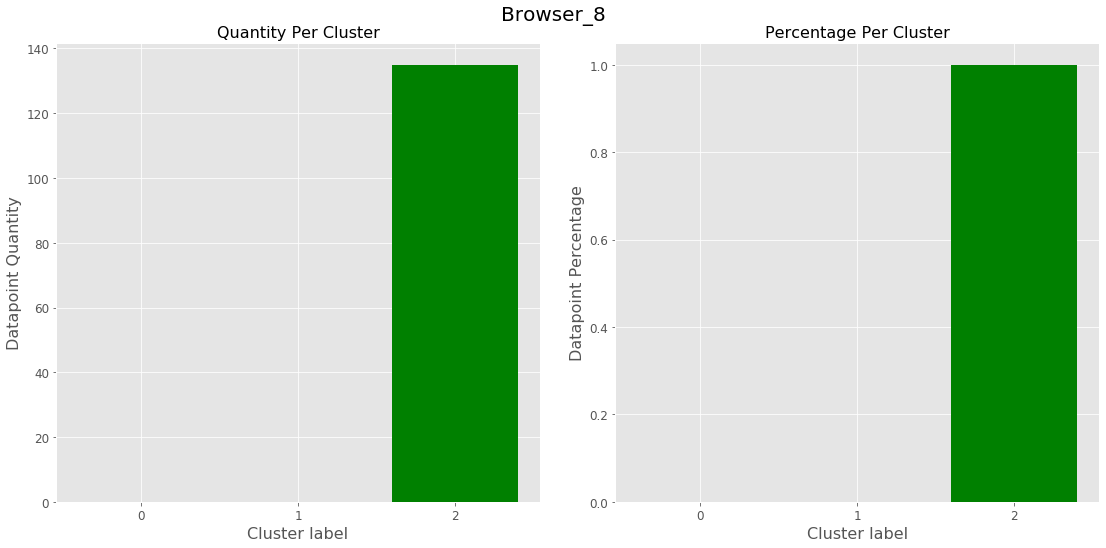

In [11]:
features = ['Browser_Other', 'TrafficType_20', 'Browser_8']
f.graph_differences_cat(data, target, features)

Based on this analysis, we can make two observations. The first is that 100% of the cluster '2' used 'Browser_8', while none of the other two clusters did. This indicates that the clustering algorithm has determined that website visits using Browser_8 are sufficiently unique as to warrant a separate cluster. This could be due either to the fact that just over 1% of visits used 'Browser_8', that visits using 'Browser_8' differed significantly from other visits, or both.

The second observation is that, although some cluster '0' datapoints use browsers in the 'Browser_Other' category, and some datapoints from both clusters '0' and '1' use 'TrafficType_20', both features are strongly correlated with cluster '1'. This indicates that there may be significant overlap in the two categories.

In order to get a better idea of this overlap, we will plot both the 'Browser_Other' and 'TrafficType_20' categories
again, this time distinguishing datapoints in which both categories overlap.

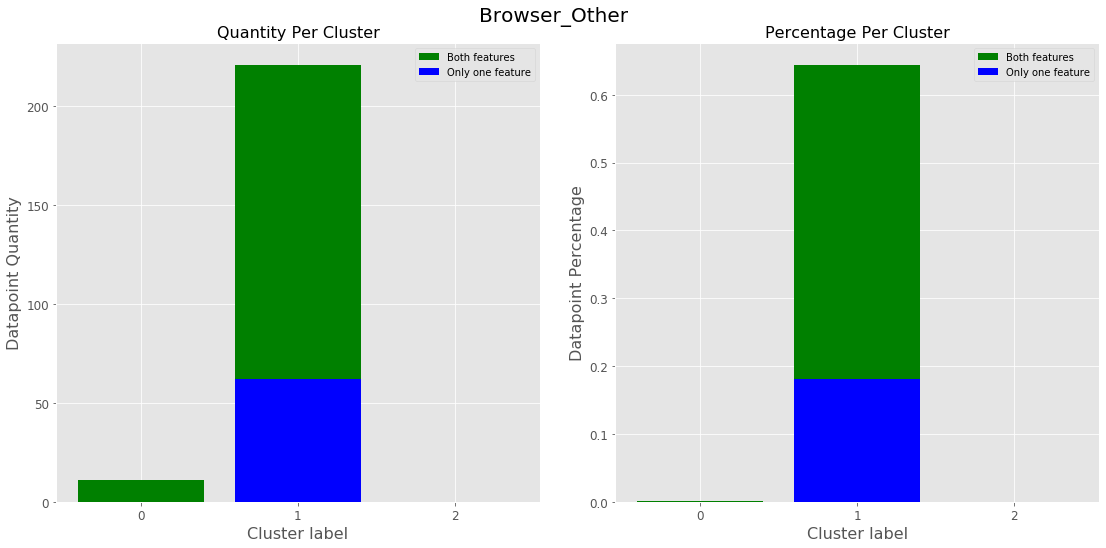

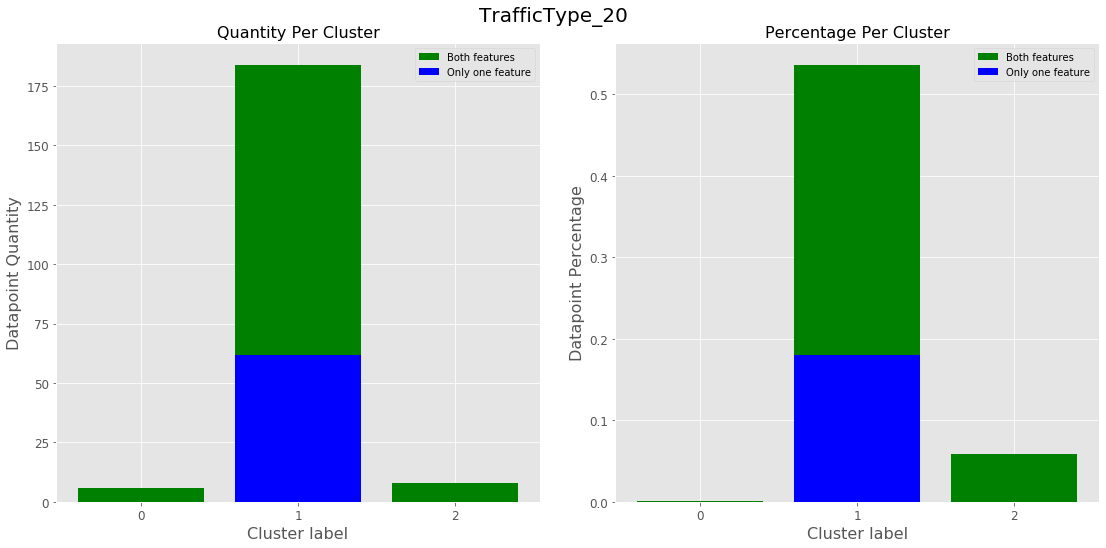

In [12]:
features = ['Browser_Other', 'TrafficType_20']
f.graph_differences_cat(data, target, features, overlap=True)

From this analysis, we can see that cluster '1' has a significant overlap between visits using browsers in the "Other" category and visits using TrafficType_20. Since none of the other clusters have datapoints that overlap in this way, it's likely either that (at least some) browsers in the "Other" category use TrafficType_20 more frequently, or, since the "Browser_Other" category comprises several rarely-used browsers, at least one of these browsers uses TrafficType_20 exclusively.

However, while this might explain some of the overlap between the "Browser_Other" and "TrafficType_20" categories in cluster "1", the majority of the cluster '1' datapoints shown do not have overlap in their features. In addition, we still do not know how many datapoints in cluster '1' don't belong to either category. We will now check the percentage of cluster '1' datapoints that belong to both the 'Browser_Other' category and the 'TrafficType_20_Only' categories, the percentage that belong to only one category, and the percentage that belong to neither category.

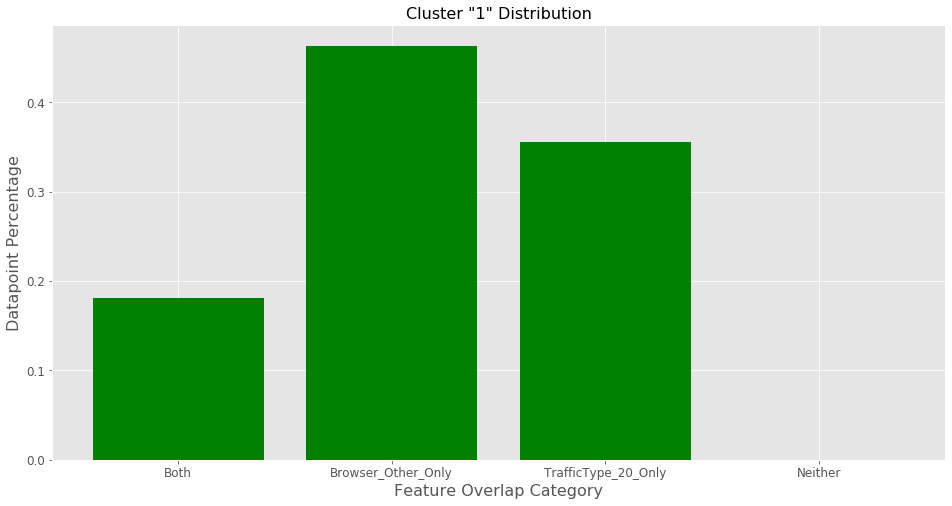

In [13]:
f.cluster_1_composition(data, target)

Based on this analysis, we can see that each of the cluster '1' datapoints belongs to at least one of these two categories. However, the fact that the two categories overlap in less than 20% of the datapoints, and the fact that neither the "Browser_Other" nor "TrafficType_20" categories are exclusive to cluster "1" both indicate that at least one other factor is contributing to cluster "1".

We will now begin exploring the rest of the "important features". We will start by plotting the distribution of the next important binary variable, "OperatingSystems_1".

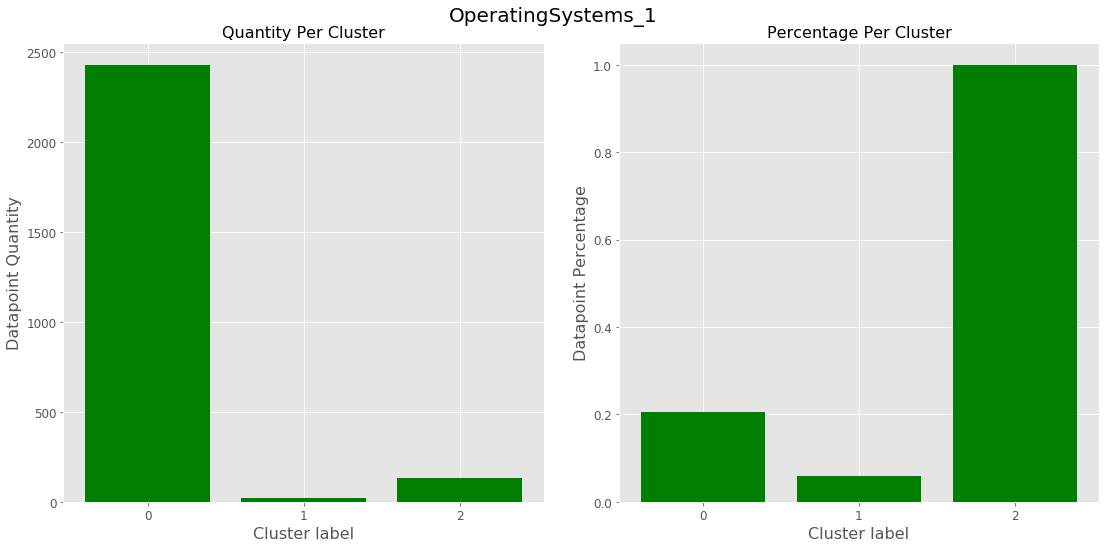

In [14]:
features = ["OperatingSystems_1"]
f.graph_differences_cat(data, target, features)

Regarding "OperatingSystems_1", although cluster '0' has a larger overall quantity, 100% of datapoints in cluster "2" use "OperatingSystems_1", indicating that "Browser_8" probably exclusively uses "OperatingSystems_1" (although the inverse is not true). This is probably the cause of this feature's importance. However, since very few of the datapoints belong to the "1" cluster, this doesn't help us.

Next, we will move on to next three most important features: 'ProductRelated_Duration', 'ExitRates', and 'ProductRelated'. We will divide each into quantiles of 10, and plot the distributions of each cluster using bar plots. Since the clusters are unbalanced, we will look at the total percentage of each cluster allocated to each quantile. In order to better analyze this, we will fully clean the dataset. Although we are mainly trying to
compare clusters "0" and "1", we will include cluster "2" for comparison.

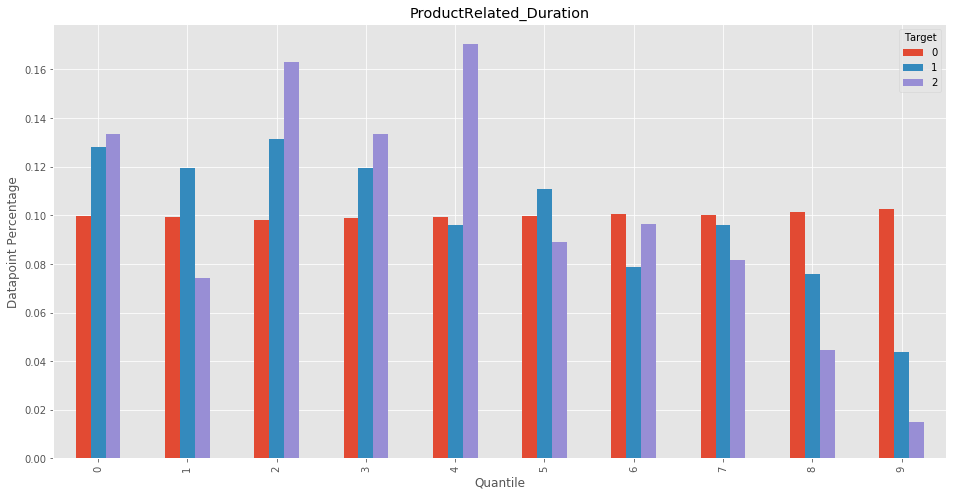

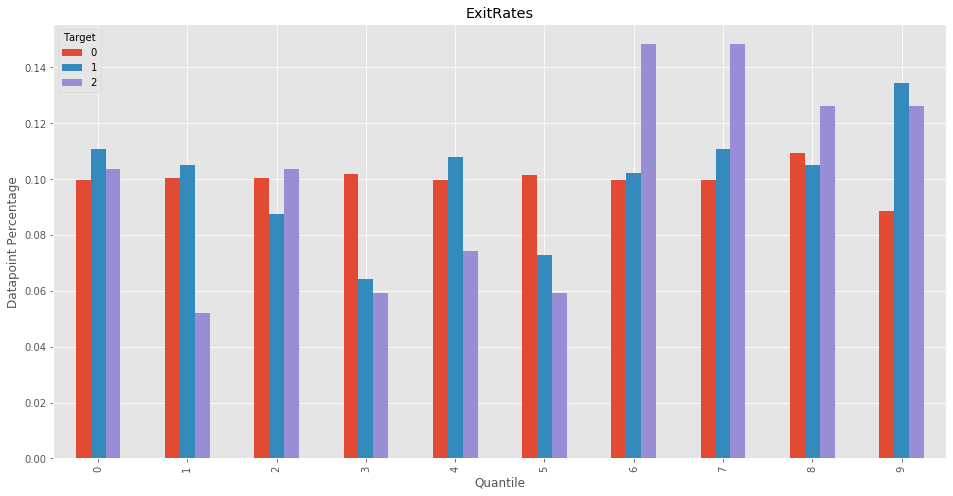

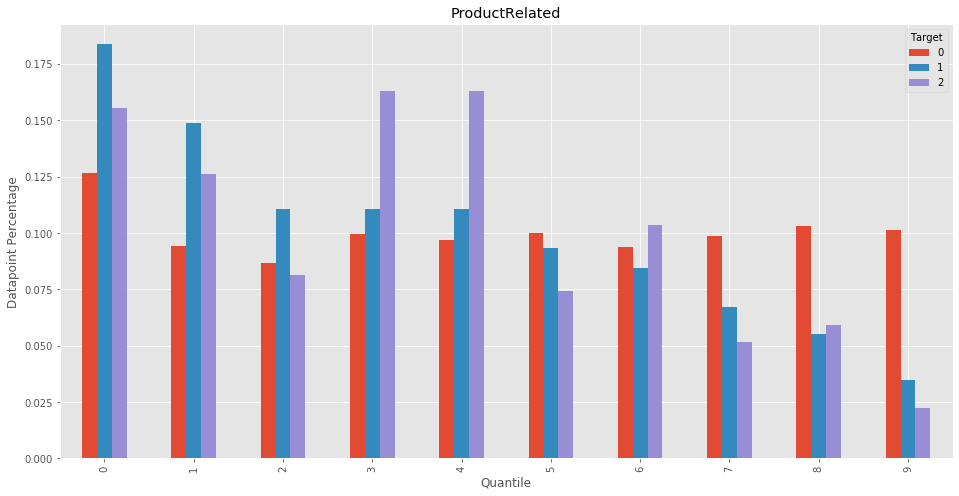

In [15]:
data = pd.read_csv('data/shoppers.csv')
data = d.clean(data)

f.plot_continuous(data, target)

From this analysis, we can see that in almost each quantile of each of the three categories, cluster "0" hovers around 10%. This is to be expected, since this cluster contains over 95% of the dataset. Clusters "1" and "2", however, both appear to visit less product-related pages, and seem to spend comparatively less time viewing product-related pages. Regarding the exit rates, datapoints in cluster "1" have visited pages either with lower-than-average exit rates or higher-than-average exit rates, and datapoints in cluster "2" are more likely to have visited pages with high exit rates.

These graphs indicate that on the whole, users in cluster "0" are more likely to visit and spend time at product-related pages, either because they are more likely to visiting the website with the intention of purchasing something, or because they are logistically in the position to be spending more time looking at the website (ex. home computer v. smartphone).

However, in order to determine how the datapoints in cluster "0" with either 'Browser_Other' or 'TrafficType_20' compare to those in cluster "1". We will recreate these graphs, but instead of including all of cluster "0", we will only include the 17 datapoints that meet this benchmark.

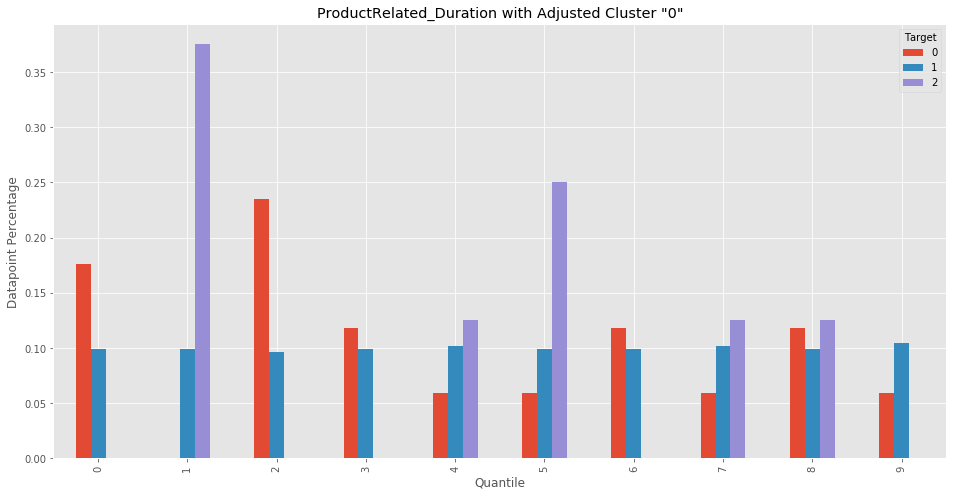

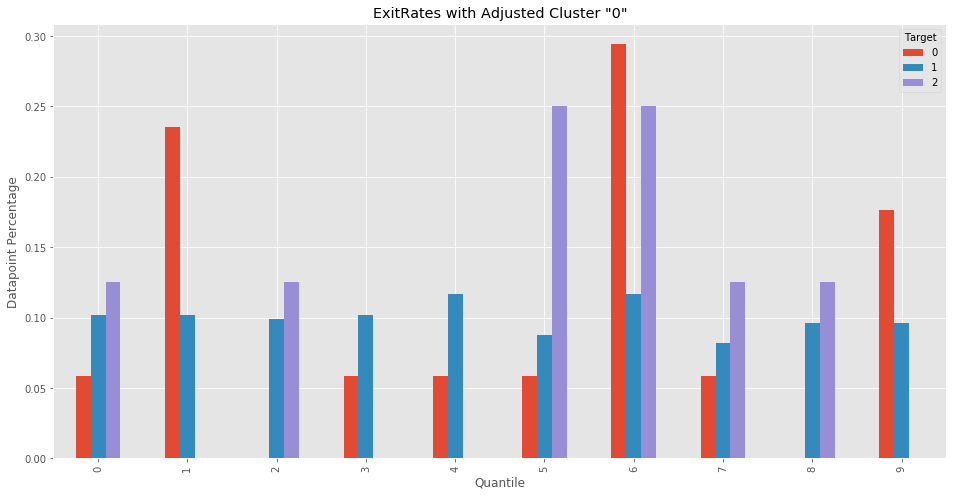

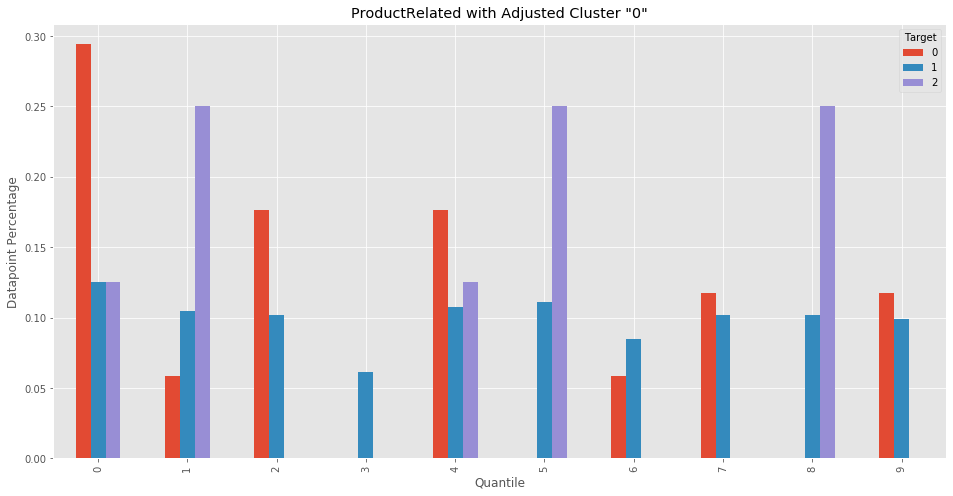

In [16]:
f.plot_continuous(data, target, new_cluster_0=True)

From this analysis, although the exit rate levels for the remaining cluster "0" and "2" datapoints are uneven, they seem to increase dramatically in the 50-70% range. We can see that many of the remaining cluster "0" and "2" datapoints are less likely to visit product pages than both cluster "1" datapoints and other cluster "0" / "2" datapoints. In addition, they are more likely to spend less time on these pages.

This indicates that a large way that the users in cluster "1" and the users in cluster "0" or "2" with either 'Browser_Other' or 'TrafficType_20' may differ is that they are more likely to visit and spend time on product pages.
It may be these users are visiting non-product pages with comparatively high exit rates.

Although this may not account fully for the differences between cluster "1" datapoints and datapoints in cluster "0" or "2" with either an "Other" browser or a traffic type 20, it may be that the remaining variance relates to information lost during the principal component analysis. For this reason, moving forward, we will label the clusters in the following way:
* **O:** "Others"
* **1:** "Product-interested Traffic Type 20 and/or Rare Browser users"
* **2:** "Browser 8 users"

In [17]:
target = f.label_clusters(target)

## Preforming Classification on the Labelled Dataset
Our next step will be to test the efficacy of our labels by preforming machine learning classification. We will first reload the uncleaned dataset and prepare it. This means that aside from our first two cleaning steps (changing categorical integer values to strings and grouping rare categorical values), we will need to obtain viable training and test datasets. Since we know that our targets are very imbalanced, we will need to stratify the test datasets, and preform resampling on our training values. Since our dataset contains categories, we will use SMOTENC to create synthetic datapoints for our minority classes.

Following the resampling, we will preform the remaining data transformations on both the training and test features. In order to prevent leakage, we will make sure not to use the test features in determining either the value to add to zero points prior to log transformation or the value to cap continuous outliers. We will likewise not use it to fit the standardization algorithm.

In [18]:
data = pd.read_csv('data/shoppers.csv')
data = data.join(target)

X_train, X_test, y_train, y_test = d.clean(data, target=True)

Our next step will be to create a machine learning algorithm, and to fit it to our training dataset. For our model, we will be training a logistic regression algorithm. We will use a logistic regression, because this model is less susceptible than Random Forests to overfitting. In addition, since we have over 60 features, it requires less computing power than either Support Vector Machines or K Nearest Neighbor.

Prior to fitting our logistic regression, we will run GridSearchCV in order to determine the appropriate C, fit intercept, and solver will bring us the best results. These parameters will automatically be incorporated into the resulting logistic regression. Since we want to minimize both false positive and false negative mistakes, and since the regression is multinomial, we will be using F1 Micro to determine our best GridSearchCV result.

Test Accuracy score:  0.8410638987998702
Test F1 score:  0.8410638987998701


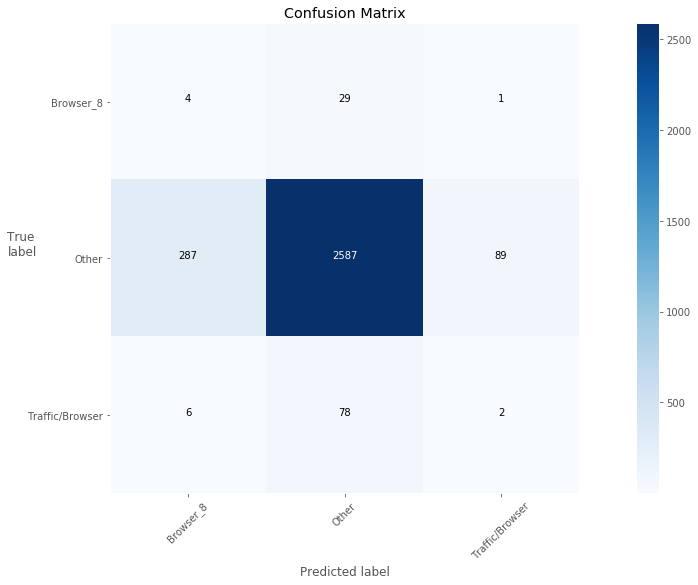

In [19]:
f.log_results(X_train, X_test, y_train, y_test)

The resulting accuracy and F1 scores are above 80%, which is usually considered very positive. However, we can see from the results that the system does a much better job at predicting the 'Other' category than it does either the 'Browser_8' or the 'TrafficType20/Rare_Browser/Product-Interested" Group. In fact, the algorithm is only able to correctly predict both of these groups a total of less than ten times. Since the percentage of each minority label is predicted to be in the majority class, this suggests that the algorithm still has difficulty distinguishing these.

Since the criteria for both groups is fairly confined to only a few categories, a boosted system might be a good next step, as it might be more capable of determining these categories by focusing on incorrect labels. In addition, we might want to investigate whether transforming the continuous data, removing outliers and scaling data prior to creating the synthetic training group might produce a more accurate training dataset.

## Conclusion

Using unsupervised clustering, we have been able to separate the "Shopper Intention" dataset into a majority label, as well as two minority labels. We then used feature importance to analyze the clusters, and found that the minority label designations are primarily related to rare technical demographics. Finally, we fit a logistic regression algorithm to our dataset, and had some success in predicting the labels.

For the purposes of productionization, enclosed is a diagram demonstrating the steps to productionizing this process.